week9 objectives:

1. train on extracted features and set a baseline for multimodal emotion recognition
2. hyper-parameter tuning with grid search cross validation

In [1]:
# https://charlesreid1.github.io/circe/Digit%20Classification%20-%20PCA%20and%20SVC.html

In [1]:
%matplotlib inline

import numpy as np

# plots
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [3]:
# load data
FEATURES_PATH = "../w8/feature/"

aco, label = np.load(f"{FEATURES_PATH}/acoustic_0.npy"), np.load(F"{FEATURES_PATH}/label_0.npy").reshape(-1, 1)

for i in range(1, 6):
    # load chunk
    aco_i, label_i = np.load(f"{FEATURES_PATH}/acoustic_{i}.npy"), np.load(F"{FEATURES_PATH}/label_{i}.npy")
    # stack
    aco, label = np.vstack((aco, aco_i)), np.vstack((label, label_i.reshape(-1, 1)))


print(f"acoustic: {aco.shape}", f"labels: {label.shape}")


acoustic: (1441, 64) labels: (1441, 1)


In [4]:
# split
x_train, x_test, y_train, y_test = train_test_split(aco, label.ravel(), random_state=101, test_size=0.2)

print(x_train.shape, y_train.shape)


(1152, 64) (1152,)


In [5]:
# dimensionality reduction
pca_ = PCA(n_components=30, whiten=True)

pca_.fit(x_train)
x_train_red = pca_.transform(x_train)

x_train_red.shape

(1152, 30)

In [6]:
steps = [
    ('pca', PCA()),
    ('scaler', StandardScaler()),
    ('clf', SVC())
    ]
        
pipe = Pipeline(steps)


In [7]:
params = {
    'pca__n_components' : [15, 30, 45, 60],
    'clf__kernel' : ['linear', 'rbf'],
    'clf__gamma' : ['scale', 'auto']
}

gs = GridSearchCV(estimator=pipe, param_grid=params, scoring='accuracy', verbose=1)

gs.fit(x_train, y_train)

print(f"best params: {gs.best_params_}")


from sklearn.metrics import accuracy_score

y_pred = gs.predict(x_test)
acc = accuracy_score(y_test, y_pred)

print(f"test accuracy: {acc}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
best params: {'clf__gamma': 'auto', 'clf__kernel': 'rbf', 'pca__n_components': 30}
test accuracy: 0.6262975778546713


In [8]:
# without tuning
svc = pipe.fit(x_train, y_train)

train_acc = float(svc.score(x_train, y_train))

print("---- train accuracy %s ----" % round(train_acc, 4))

predictions = svc.predict(x_test)

print("---- test accuracy %s ----" % round(accuracy_score(y_test, predictions), 4))

---- train accuracy 0.9175 ----
---- test accuracy 0.5744 ----


In [9]:
labels = {1: "neutral", 2: "calm", 3: "happy", 4: "sad", 5: "angry", 6: "fearful", 7: "disgust", 8: "surprised"}


list(labels.values())

['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

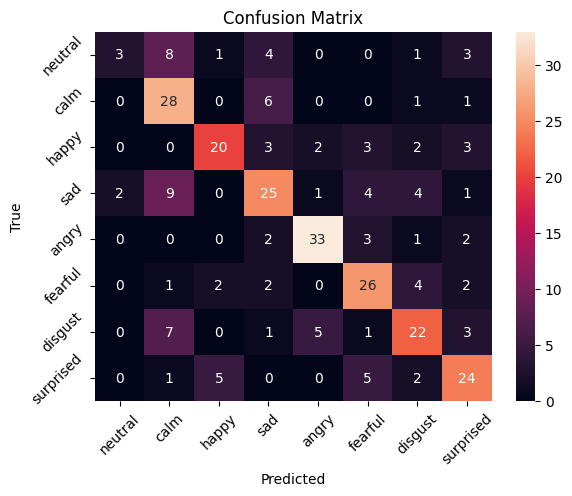

In [10]:
ax= plt.subplot()

predictions = gs.predict(x_test)
cm = confusion_matrix(y_test, predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); 

ax.set_title("Confusion Matrix"); 
ax.xaxis.set_ticklabels(list(labels.values()), rotation=45); ax.yaxis.set_ticklabels(list(labels.values()), rotation=45);

In [11]:
print("---- test accuracy %s ----" % round(accuracy_score(y_test, predictions), 4))

---- test accuracy 0.6263 ----


In [12]:
print(classification_report(y_test, predictions, target_names=list(labels.values())))

              precision    recall  f1-score   support

     neutral       0.60      0.15      0.24        20
        calm       0.52      0.78      0.62        36
       happy       0.71      0.61      0.66        33
         sad       0.58      0.54      0.56        46
       angry       0.80      0.80      0.80        41
     fearful       0.62      0.70      0.66        37
     disgust       0.59      0.56      0.58        39
   surprised       0.62      0.65      0.63        37

    accuracy                           0.63       289
   macro avg       0.63      0.60      0.59       289
weighted avg       0.63      0.63      0.62       289



In [13]:
import pickle

with open('svc.p', 'wb') as f:
    pickle.dump(gs, f)


main: train a baseline and optimize hyperparameters with grid search cross validation, saved the model as pickle- svc.p